# Template for Spectral and temporal modifications Lab


*From R. Badeau and G. Richard (with help from P. Vernhet); MAJ:2019,2024*

**python version >=3.6**

        ** Iliass LASRI **

In [69]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython
from copy import deepcopy
from math import ceil
import soundfile as sf
import scipy

## Functions

In [70]:
def plot_sound(data, times, name="default_name", save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel("time (s)")
    plt.ylabel("amplitude")
    if save:
        plt.savefig(name + ".png", dpi=100)
    plt.show()


def nextpow2(x):
    assert x > 0
    p = ceil(np.log2(x))
    x_ = 2**p
    assert 2 ** (p - 1) < x <= x_
    return x_


def period(x, Fs, Pmin=1 / 300, Pmax=1 / 80, seuil=0.7):
    # [P,voiced] = period(x,Fs,Pmin,Pmax,seuil);
    # If voiced = 1, P is the period signal x expressed in number of samples
    # If voiced = 0, P is equal to 10ms.Fs

    x = x - np.mean(x)
    N = len(x)

    Nmin = np.ceil(Pmin * Fs).astype(int)
    Nmax = 1 + np.floor(Pmax * Fs).astype(int)
    Nmax = np.min([Nmax, N])

    Nfft = nextpow2(2 * N - 1)
    X = np.fft.fft(x, n=Nfft)
    S = X * np.conj(X) / N
    r = np.real(np.fft.ifft(S))

    rmax = np.max(r[Nmin:Nmax])
    I = np.argmax(r[Nmin:Nmax])
    P = I + Nmin
    corr = (rmax / r[0]) * (N / (N - P))
    voiced = corr > seuil
    if not (voiced):
        P = np.round(10*10e-3 * Fs)

    return P, voiced

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [71]:
filename = 'aeiou.wav'
file_path = os.path.join(os.getcwd(), filename) 

### **Using Soundfile**

In [72]:
x, Fs= sf.read(file_path)

In [73]:
IPython.display.Audio(file_path)

In [74]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

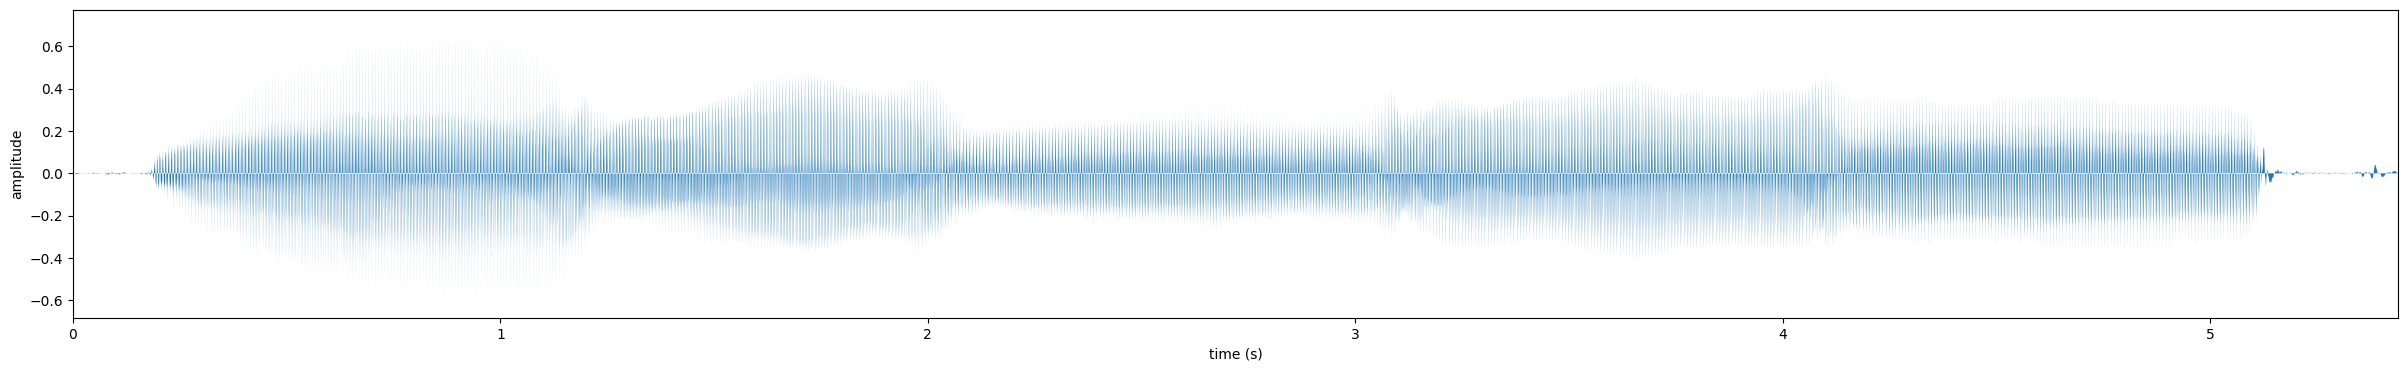

In [75]:
plot_sound(x, times)

In [76]:
sf.write('new_aeiou.wav',x, samplerate=Fs) # to write a new wave file

    1. Extraction of the analysis marks

Remark : we should always work with t as indexes, in this case at least.

In [77]:
def AnalysisPitchMarks(s, Fs):
    A = np.zeros((3, len(s)))
    n = 1
    # init
    A[0, 0] = 0
    A[2, 0] = 10*10e-3 * Fs

    # recursion
    while(True):
        t = A[0, n-1]
        duration = 2.5 * A[2, n-1]
        if(int(t+ duration) >= len(s)):        # break when exceed time window
            break
        extracted_window = x[int(t): int(t+ duration)]

        A[2, n], A[1, n] = period(extracted_window, Fs)
        
        next_t = int(t + A[2, n])

        A[0, n] = next_t
        n+=1
    A = A[:, :n]
    return A

In [78]:
A = AnalysisPitchMarks(x, Fs)
A

array([[0.0000e+00, 7.8000e+01, 1.1800e+03, ..., 5.6183e+04, 5.6267e+04,
        5.7369e+04],
       [0.0000e+00, 1.0000e+00, 0.0000e+00, ..., 1.0000e+00, 1.0000e+00,
        0.0000e+00],
       [1.1025e+03, 7.8000e+01, 1.1020e+03, ..., 8.3000e+01, 8.4000e+01,
        1.1020e+03]])

    2. Synthesis and modification of the temporal and spectral scales

synthesis without modification

In [79]:
B = np.zeros((2, len(A[0, :])-1))

B[0, :] = A[0, :-1]
B[1, :] = [i for i in range(1, len(A[0, :]))]

print("Shape of B: ", B.shape)
print("Shape of A: ", A.shape)
B

Shape of B:  (2, 654)
Shape of A:  (3, 655)


array([[0.0000e+00, 7.8000e+01, 1.1800e+03, ..., 5.6100e+04, 5.6183e+04,
        5.6267e+04],
       [1.0000e+00, 2.0000e+00, 3.0000e+00, ..., 6.5200e+02, 6.5300e+02,
        6.5400e+02]])

This is a synthesis because we want to know the times of the shanks (where to put them), and the index of the chanks (which shank to put). 

2.1 Signal synthesis

In [80]:
def Synthesis(s, Fs, A, B):
    # init y 
    # zero vector of dimension ts(kend) + Pa(n(kend))
    ts_kend = int(B[0, -1])
    n_kend = int(B[1, -1])
    Pa_n_kend = int(A[2, n_kend])
    y = np.zeros(ts_kend + Pa_n_kend)

    k = 1
    while(k < len(B[0,:])):
        # extract window centered on s
        n_k = int(B[1, k])
        t = int(A[0, n_k])
        duration = int(A[2, n_k])

        t_start = t - duration
        t_end = t + duration + 1

        extracted_seq = s[t_start: t_end]
        # windowing
        window = scipy.signal.windows.hann(len(extracted_seq))
        windowed_sig = extracted_seq * window

        ts = int(B[0, k])
        t_start = ts - duration
        t_end = ts + duration

        # overlap-add
        if(len(y[t_start: t_end]) > len(windowed_sig)):
            y[t_start: t_end] += np.pad(windowed_sig, (0, len(y[t_start: t_end]) - len(windowed_sig)), 'constant')
        else : 
            y[t_start: t_end] += windowed_sig[:len(y[t_start: t_end])]
        k += 1
    return y

In [81]:
y = Synthesis(x, Fs, A, B)
print("The length of the original signal is: ", len(x))
print("The length of the synthesized signal is: ", len(y))

# original sound
IPython.display.Audio(x, rate=Fs)

The length of the original signal is:  59964
The length of the synthesized signal is:  57369


In [82]:
# synthesized sound
IPython.display.Audio(y, rate=Fs)

    We can see that its the same as the original signal, but with a different number of samples.

    2.1. Modification of the temporal scale

function B = ChangeTimeScale(alpha,A,Fs)

In [83]:
def ChangeTimeScale(alpha, A, Fs):
    B = np.zeros((2, alpha * len(A[0, :])))
    # init
    B[0, 0] = 0
    B[1, 1] = 1
    k = 1
    while(B[1, k] + 1/alpha < len(A[0, :])):
        ts_k_1 = B[0, k-1]
        n_k = int(B[1, k])
        pa = A[2, n_k]

        B[0, k] = ts_k_1 + pa
        B[1, k+1] = B[1, k] + 1/alpha
        
        k += 1

    # floor all values
    B[0, :] = np.floor(B[0, :])
    B[1, :] = np.floor(B[1, :])
    return B

In [96]:
def ChangeTimeScale(alpha, A, Fs):
    # B = np.zeros((2, alpha * len(A[0, :])))
    # init
    B_ts = [0]
    B_n = [0, 1]
    k = 1
    while(B_n[k-1] + 1/alpha < len(A[0, :])):
        ts_k_1 = B_ts[k-1]
        n_k = int(B_n[k])
        pa = A[2, n_k]

        B_ts.append(ts_k_1 + pa)
        B_n.append(B_n[k] + 1/alpha)
        
        k += 1
    B = np.zeros((2, len(B_ts) - 1))
    B[0, :] = B_ts[:-1]
    B[1, :] = B_n[1:-1]

    # floor all values
    B[0, :] = np.floor(B[0, :])
    B[1, :] = np.floor(B[1, :])
    
    return B

In [97]:
alpha = 2
B = ChangeTimeScale(alpha, A, Fs)
print(B.shape)
print(A.shape)

(2, 1308)
(3, 655)


In [99]:
# synthesis
y = Synthesis(x, Fs, A, B)

print("The length of the original signal is: ", len(x))
print("The length of the synthesized signal is: ", len(y))

print(" --------- \n Synthesized sound")
IPython.display.Audio(y, rate=Fs)

The length of the original signal is:  59964
The length of the synthesized signal is:  114738
 --------- 
 Synthesized sound




### Modification of the spectral scale

function B = ChangePitchScale(beta,A,Fs)

In [100]:
def ChangePitchScale(beta,A,Fs):
    """
    Change the pitch scale of a sound signal
    """
    B_ts = [0]
    B_n = [0, 0]
    k = 1
    while(True):
        n_k = int(B_n[k])
        voiced = A[1, n_k]
        if(voiced):
            scale = 1/beta
        else:
            scale = 1

        ts_k_1 = B_ts[k-1]
        pa = A[2, n_k]
        
        B_ts.append(ts_k_1 + scale * pa)
        B_n.append(B_n[k] + scale)
        k += 1
        if(B_n[k] >= len(A[0, :])):
            break
    
    B = np.zeros((2, len(B_ts) - 1))

    B[0, :] = B_ts[:-1]
    B[1, :] = B_n[1:-1]
    
    # floor
    B[0, :] = np.floor(B[0, :])
    B[1, :] = np.floor(B[1, :])
    return B

In [104]:
beta=7
B = ChangePitchScale(beta, A, Fs)
print(B.shape)
print(A.shape)

(2, 4561)
(3, 655)


In [105]:
y = Synthesis(x, Fs, A, B)

print("The length of the original signal is: ", len(x))
print("The length of the synthesized signal is: ", len(y))
print("----- --- --- --- \n Original sound :")
IPython.display.Audio(x, rate=Fs)

The length of the original signal is:  59964
The length of the synthesized signal is:  58469
----- --- --- --- 
 Original sound :


In [106]:
print("Synthesized sound :")
IPython.display.Audio(y, rate=Fs)

Synthesized sound :


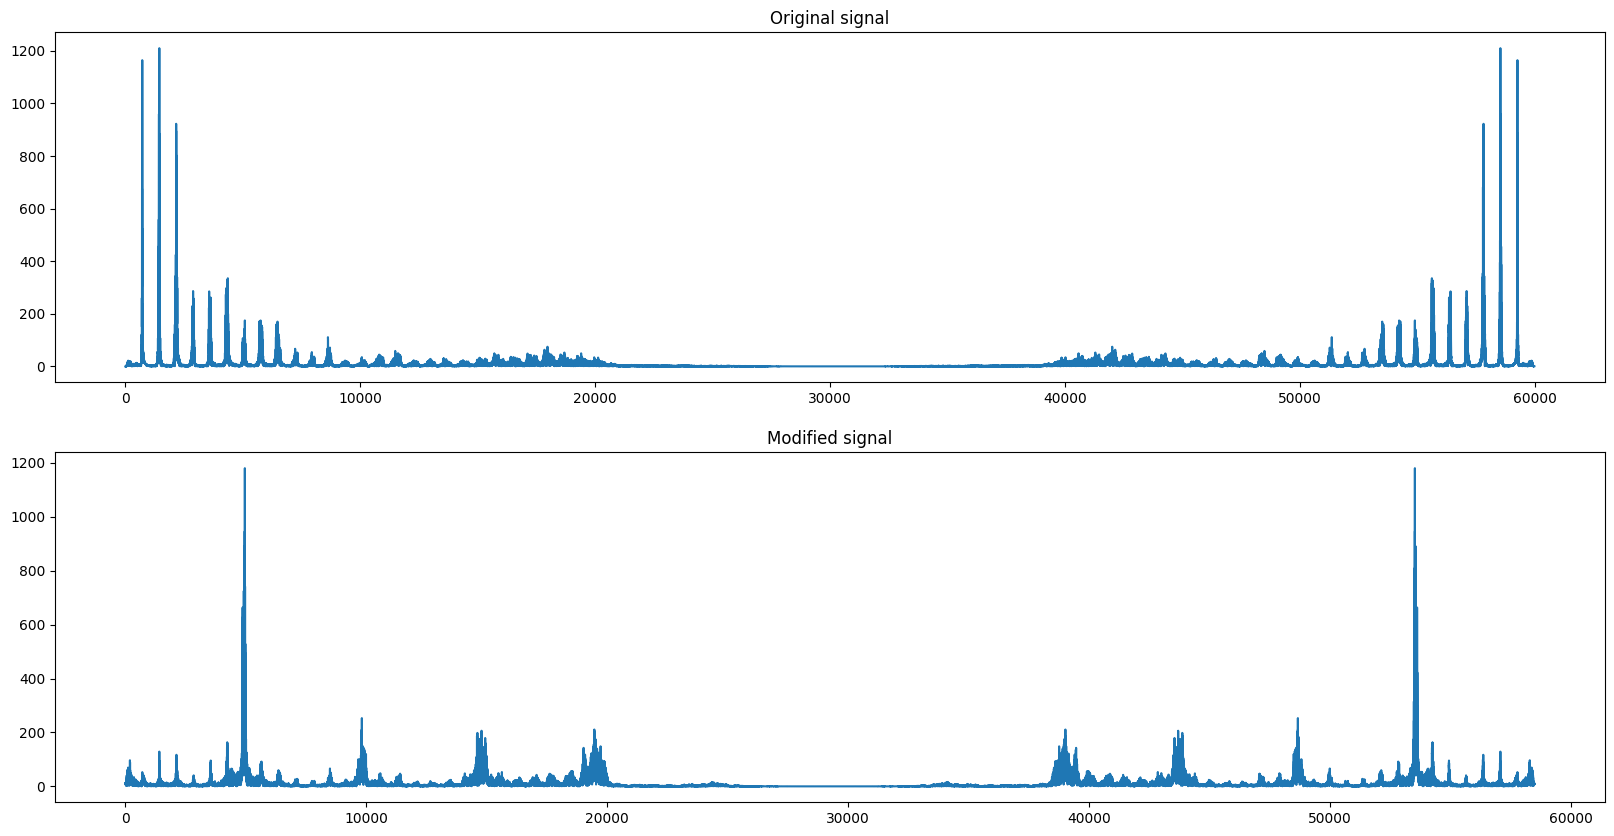

In [107]:
fft_x = np.fft.fft(x)
fft_y = np.fft.fft(y)
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.plot(np.abs(fft_x))
plt.title("Original signal")


plt.subplot(2, 1, 2)
plt.plot(np.abs(fft_y))
plt.title("Modified signal")

plt.show()

### Joint modification of the temporal and spectral scales

In [108]:
def ChangeBothScales(alpha, beta, A, Fs):
    # init
    B_ts = [0]
    B_n = [0, 1]
    k = 1
    scale = 1
    while(B_n[k-1] + scale/alpha < len(A[0, :])):
        ts_k_1 = B_ts[k-1]
        n_k = int(B_n[k])
        pa = A[2, n_k]

        voiced = A[1, n_k]
        
        if(voiced):
            scale = 1/beta
        else:
            scale = 1
        
        B_ts.append(ts_k_1 + scale * pa)
        B_n.append(B_n[k] + scale/alpha)
        
        k += 1
    B = np.zeros((2, len(B_ts) - 1))
    B[0, :] = B_ts[:-1]
    B[1, :] = B_n[1:-1]

    # floor
    B[0, :] = np.floor(B[0, :])
    return B

In [113]:
B = ChangeBothScales(alpha=2, beta=6, A=A, Fs=Fs)

In [114]:
y = Synthesis(x, Fs, A, B)

print("The length of the original signal is: ", len(x))
print("The length of the synthesized signal is: ", len(y))
print("----- --- --- --- \n Original sound :")
IPython.display.Audio(x, rate=Fs)

The length of the original signal is:  59964
The length of the synthesized signal is:  114737
----- --- --- --- 
 Original sound :


In [118]:
print("Synthesized sound :")
IPython.display.Audio(y, rate=Fs)

Synthesized sound :
